In [1]:
import csv
import json
import os
from glob import glob
from typing import Dict, List, Optional, Tuple, Union, Callable

import gym
import numpy as np
import pandas
import matplotlib.pyplot as plt
import warnings

from stable_baselines3.common.type_aliases import GymObs, GymStepReturn
from stable_baselines3.common.callbacks import BaseCallback, EventCallback
from stable_baselines3.common import logger
from stable_baselines3 import A2C, SAC, PPO, TD3, HER, DQN
from stable_baselines3.common.vec_env import VecEnv, sync_envs_normalization, DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.results_plotter import load_results, ts2xy

In [2]:
import os, sys

module_path = os.path.abspath(os.path.join('.'))
# if module_path not in sys.path:
sys.path.append(module_path + "/gym/envs/classic_control")
sys.path.append(module_path + "/gym/envs/mujoco")
print('{}'.format(sys.path))

['/Users/yujiazhang/gym', '/Users/yujiazhang/opt/anaconda3/lib/python38.zip', '/Users/yujiazhang/opt/anaconda3/lib/python3.8', '/Users/yujiazhang/opt/anaconda3/lib/python3.8/lib-dynload', '', '/Users/yujiazhang/opt/anaconda3/lib/python3.8/site-packages', '/Users/yujiazhang/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/Users/yujiazhang/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/Users/yujiazhang/.ipython', '/Users/yujiazhang/gym/gym/envs/classic_control', '/Users/yujiazhang/gym/gym/envs/mujoco']


From the plot, we can see the following: If you die on the main task, you will fail the subtask a few steps earlier; in other words, the subtask serves as an early warning


In [3]:
from humanoidstandup import HumanoidStandupEnv

from Evaluate_training_performance import EvalCallback, evaluate_policy

In [4]:
eval_env = HumanoidStandupEnv()


body mass [0.         8.32207894 2.03575204 5.85278711 4.52555626 2.63249442
 1.76714587 4.52555626 2.63249442 1.76714587 1.59405984 1.19834313
 1.59405984 1.19834313]


In [ ]:
#env = HumanoidStandupEnv()

eval_env = HumanoidStandupEnv()

model = A2C('MlpPolicy', eval_env, verbose = 1)

n_iterations = 100

learning_steps = 1000
eval_episodes = 10
sim_steps_upper_bound = 100


rewards = np.zeros((n_iterations, 2))
infos = []


for n_iter in range(n_iterations):
    print('iteration {} started'.format(n_iter))
    model.learn(total_timesteps = learning_steps)
    print('iteration {} learning completed'.format(n_iter))
    episode_rewards, episode_lengths, episode_infos, info_names = \
        evaluate_policy(model, eval_env, 
                        n_eval_episodes = eval_episodes, 
                        sim_steps_upper_bound = sim_steps_upper_bound ,
                        return_episode_rewards = True)

    reward_mean, reward_std = np.mean(episode_rewards), np.std(episode_rewards)
    episode_infos_array = np.stack(episode_infos)
    episode_infos_mean, episode_infos_std = np.mean(episode_infos_array, axis=0), np.std(episode_infos_array, axis=0)
    
    rewards[n_iter] = np.array([reward_mean, reward_std])
    infos.append([episode_infos_mean, episode_infos_std])
    
    #print(episode_rewards, episode_infos, info_names)

body mass [0.         8.32207894 2.03575204 5.85278711 4.52555626 2.63249442
 1.76714587 4.52555626 2.63249442 1.76714587 1.59405984 1.19834313
 1.59405984 1.19834313]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
iteration 0 started
------------------------------------
| time/                 |          |
|    fps                | 559      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -24      |
|    explained_variance | -0.00881 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 3.36e+03 |
|    std                | 0.995    |
|    value_loss         | 2.15e+04 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 585      |
|    iterations         | 200      |
|    time_elaps

In [7]:
output = [np.array([462.71253645,  -1.61314899,   0.        ,   4.51656018]), 
          np.array([466.91246173,  -1.71802641,   0.        ,   4.65668938]), 
          np.array([462.78519524,  -1.69103462,   0.        ,   4.70191263]), 
          np.array([479.77981051,  -1.62369104,   0.        ,   4.54450012]), 
          np.array([453.83008405,  -1.61901587,   0.        ,   4.59985452])] 


In [18]:
output_stacked = np.stack(output)

np.std(output_stacked, axis=0)

array([8.44745008, 0.0430746 , 0.        , 0.06865297])

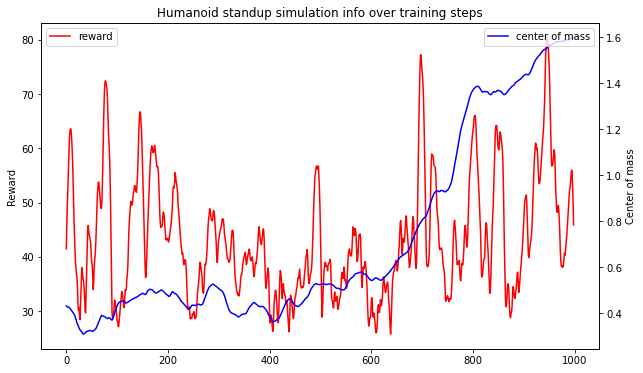

In [21]:
df = load_results(log_dir_humanoid)

rewards = df['r']
rewards_per_step = []

sub_rewards = df['sub_r']
sub_rewards_per_step = []
for i in range(1,len(rewards)):
    rewards_per_step.append(rewards[i]-rewards[i-1])
    sub_rewards_per_step.append(sub_rewards[i]-sub_rewards[i-1])

    
    
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(rewards_per_step, color = 'red', label='reward')
ax.set_ylabel("Reward")

ax2 = ax.twinx()
ax2.plot(sub_rewards_per_step, color='blue', label='center of mass')
ax2.set_ylabel('Center of mass')

ax.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
plt.title('Humanoid standup simulation info over training steps')
plt.show()

# reward here should be the vertical velocity/position? of the abdomen
# minus some control and impact cost


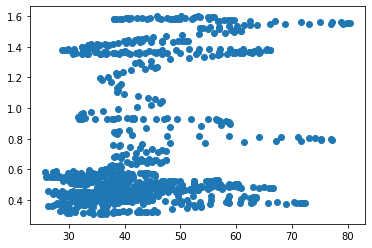

In [22]:
plt.scatter(rewards_per_step, sub_rewards_per_step)

In [16]:
log_dir_humanoid = "/tmp/gym/humanoid"
os.makedirs(log_dir_humanoid, exist_ok=True)

env2 = HumanoidStandupEnv()

eval_env = DummyVecEnv([lambda: env2])
#eval_env2 = Monitor(env2, log_dir_humanoid)

model2 = A2C('MlpPolicy', eval_env, verbose=1)
eval_callback = EvalCallback(eval_env, eval_freq = 10, log_path = log_dir_humanoid, verbose = 1)
#callback = SubtasksTrainingRewardCallback(check_freq=20, log_dir=log_dir_humanoid, verbose=1)
model2.learn(total_timesteps=100, callback=eval_callback)



body mass [0.         8.32207894 2.03575204 5.85278711 4.52555626 2.63249442
 1.76714587 4.52555626 2.63249442 1.76714587 1.59405984 1.19834313
 1.59405984 1.19834313]
Using cpu device


KeyboardInterrupt: 

In [20]:
log_dir_humanoid = "/tmp/gym/humanoid"
os.makedirs(log_dir_humanoid, exist_ok=True)

env2 = HumanoidStandupEnv()

#eval_env = DummyVecEnv([lambda: env1])
eval_env2 = Monitor(env2, log_dir_humanoid)

model2 = A2C('MlpPolicy', eval_env2, verbose=0)
callback = SubtasksTrainingRewardCallback(check_freq=20, log_dir=log_dir_humanoid, verbose=1)
model2.learn(total_timesteps=1000, callback=callback)

body mass [0.         8.32207894 2.03575204 5.85278711 4.52555626 2.63249442
 1.76714587 4.52555626 2.63249442 1.76714587 1.59405984 1.19834313
 1.59405984 1.19834313]


NameError: name 'SubtasksTrainingRewardCallback' is not defined

body mass [0.         8.32207894 2.03575204 5.85278711 4.52555626 2.63249442
 1.76714587 4.52555626 2.63249442 1.76714587 1.59405984 1.19834313
 1.59405984 1.19834313]
[34.4087668742078, -0.12296227072678759, -0.0, 0.41847909039367576]
[36.72714827431584, -0.09650124585780927, -0.0, 0.4151592545486193]
[39.99198199943695, -0.09729782525702746, -0.0, 0.4133413027436494]
[43.94431377361155, -0.12019998821653939, -0.0, 0.41604556023686273]
[46.96042065968915, -0.08940630839283494, -0.0, 0.41961447665409074]
[49.4286038128272, -0.07291979003011329, -0.0, 0.4230536609681229]
[51.53875159806709, -0.06521584530199583, -0.0, 0.42649412285683697]
[53.32658856889522, -0.08887261249214357, -0.0, 0.4299353972197551]
[54.61861888081442, -0.08409593696476944, -0.0, 0.4332424759240119]
[55.637849689537305, -0.07452058809595823, -0.0, 0.43622799256079403]
[56.46025577643121, -0.09801804907781389, -0.0, 0.43906352798379766]
[56.62737073783605, -0.08461762762351739, -0.0, 0.4420450090585765]
[56.0568130

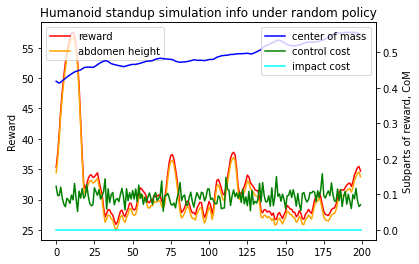

In [13]:
env = HumanoidStandupEnv()
rewards = []
sub_rewards = []

z_reward = []
control_cost = []
impact_cost = []

env.reset_model()
for t in range(200):
    #Takes a random action from its action space 
    observation, reward, done, info = env.step(env.action_space.sample())
    #print(observation)
    print(list(info.values()))
    rewards.append(reward)
    sub_rewards.append(info['subtask_1'])
    z_reward.append(info['reward_linup'])
    control_cost.append(-info['reward_quadctrl'])
    impact_cost.append(-info['reward_impact'])
    
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()

fig, ax = plt.subplots()
ax.plot(rewards, color = 'red', label='reward')
ax.plot(z_reward, color = 'orange', label='abdomen height')
ax.set_ylabel("Reward")

ax2 = ax.twinx()
ax2.plot(sub_rewards, color='blue', label='center of mass')
ax2.plot(control_cost, color = 'green', label = 'control cost')
ax2.plot(impact_cost, color = 'cyan', label = 'impact cost')
ax2.set_ylabel('Subparts of reward, CoM')

ax.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
plt.title('Humanoid standup simulation info under random policy')
plt.show()



In [12]:
mj_path, _ = mujoco_py.utils.discover_mujoco()
xml_path = os.path.join(mj_path, 'model', 'humanoid.xml')
model = mujoco_py.load_model_from_path(xml_path)
sim = mujoco_py.MjSim(model)

state_vars = ['qpos', 'qvel', 'cinert', 'cvel', 'qfrc_actuator', 'cfrc_ext']

#for i in range(len(state_vars)):
    #state_var = eval('sim.data.'+state_vars[i])
    #print(len(state_var))

    
    
n_steps = 1000

CoM_record = []

for _ in range(n_steps):
    
    #print(mass_center(model, sim))
    CoM_record.append(mass_center(model, sim))    
    #for i in range(len(state_vars)):
        #print(state_vars[i], eval('sim.data.'+state_vars[i]))
        
        
    sim.step()

plt.plot(CoM_record)
plt.title('Center of mass of humanoid over time steps')

NameError: name 'mass_center' is not defined

In [9]:
# This is copied from stable_baselines3 tutorial

class SubtasksTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq, log_dir, verbose=1):
        super(SubtasksTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf
        self.logger = logger.Logger(log_dir, 'csv')

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            # IMPORTANT: evaluate here every x stsps
            print('loaded results', '\n', load_results(self.log_dir))
            
            #x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            #print('loaded results', x,y)
            '''
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("Num timesteps: {}".format(self.num_timesteps))
                    print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model at {} timesteps".format(x[-1]))
                        print("Saving new best model to {}.zip".format(self.save_path))
                    self.model.save(self.save_path)
            '''
        return True

In [ ]:
evaluate_policy(model, eval_env, return_episode_rewards=True)

import warnings
from typing import Any, Callable, Dict, List, Optional, Tuple, Union



from stable_baselines3.common import base_class
#from stable_baselines3.common.vec_env import VecEnv, VecMonitor, is_vecenv_wrapped


def evaluate_policy(
    model: "base_class.BaseAlgorithm",
    env: Union[gym.Env, VecEnv],
    n_eval_episodes: int = 10,
    deterministic: bool = True,
    render: bool = False,
    callback: Optional[Callable[[Dict[str, Any], Dict[str, Any]], None]] = None,
    reward_threshold: Optional[float] = None,
    return_episode_rewards: bool = False,
    warn: bool = True,
) -> Union[Tuple[float, float], Tuple[List[float], List[int]]]:
    """
    Runs policy for ``n_eval_episodes`` episodes and returns average reward.
    This is made to work only with one env.

    .. note::
        If environment has not been wrapped with ``Monitor`` wrapper, reward and
        episode lengths are counted as it appears with ``env.step`` calls. If
        the environment contains wrappers that modify rewards or episode lengths
        (e.g. reward scaling, early episode reset), these will affect the evaluation
        results as well. You can avoid this by wrapping environment with ``Monitor``
        wrapper before anything else.

    :param model: The RL agent you want to evaluate.
    :param env: The gym environment. In the case of a ``VecEnv``
        this must contain only one environment.
    :param n_eval_episodes: Number of episode to evaluate the agent
    :param deterministic: Whether to use deterministic or stochastic actions
    :param render: Whether to render the environment or not
    :param callback: callback function to do additional checks,
        called after each step. Gets locals() and globals() passed as parameters.
    :param reward_threshold: Minimum expected reward per episode,
        this will raise an error if the performance is not met
    :param return_episode_rewards: If True, a list of rewards and episode lengths
        per episode will be returned instead of the mean.
    :param warn: If True (default), warns user about lack of a Monitor wrapper in the
        evaluation environment.
    :return: Mean reward per episode, std of reward per episode.
        Returns ([float], [int]) when ``return_episode_rewards`` is True, first
        list containing per-episode rewards and second containing per-episode lengths
        (in number of steps).
    """
    is_monitor_wrapped = False
    # Avoid circular import
    from stable_baselines3.common.env_util import is_wrapped
    from stable_baselines3.common.monitor import Monitor

    if isinstance(env, VecEnv):
        assert env.num_envs == 1, "You must pass only one environment when using this function"
        is_monitor_wrapped = is_vecenv_wrapped(env, VecMonitor) or env.env_is_wrapped(Monitor)[0]
    else:
        is_monitor_wrapped = is_wrapped(env, Monitor)

    if not is_monitor_wrapped and warn:
        warnings.warn(
            "Evaluation environment is not wrapped with a ``Monitor`` wrapper. "
            "This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. "
            "Consider wrapping environment first with ``Monitor`` wrapper.",
            UserWarning,
        )

    episode_rewards, episode_lengths, episode_subtask_rewards = [], [], []
    not_reseted = True
    while len(episode_rewards) < n_eval_episodes:
        # Number of loops here might differ from true episodes
        # played, if underlying wrappers modify episode lengths.
        # Avoid double reset, as VecEnv are reset automatically.
        if not isinstance(env, VecEnv) or not_reseted:
            obs = env.reset()
            not_reseted = False
        done, state = False, None
        episode_reward = 0.0
        episode_length = 0
        subtask_reward = 0
        while not done:
            action, state = model.predict(obs, state=state, deterministic=deterministic)
            obs, reward, done, info = env.step(action)
            episode_reward += reward
            subtask_reward += list(info.values())[0]
            if callback is not None:
                callback(locals(), globals())
            episode_length += 1
            if render:
                env.render()

        if is_monitor_wrapped:
            # Do not trust "done" with episode endings.
            # Remove vecenv stacking (if any)
            if isinstance(env, VecEnv):
                info = info[0]
            if "episode" in info.keys():
                # Monitor wrapper includes "episode" key in info if environment
                # has been wrapped with it. Use those rewards instead.
                episode_rewards.append(info["episode"]["r"])
                episode_lengths.append(info["episode"]["l"])
        else:
            episode_rewards.append(episode_reward)
            episode_lengths.append(episode_length)
            episode_subtask_rewards.append(subtask_reward)

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    if reward_threshold is not None:
        assert mean_reward > reward_threshold, "Mean reward below threshold: " f"{mean_reward:.2f} < {reward_threshold:.2f}"
    if return_episode_rewards:
        return episode_rewards, episode_lengths, episode_subtask_rewards
    
    return mean_reward, std_reward


In [34]:
env1 = CartPoleEnv()

n_episodes = 20


subtask_records = [None] * n_episodes

for i_episode in range(n_episodes):
    observation = env1.reset()
    subtask_performance = []
    for t in range(100):
        #env1.render()
        #print(observation)
        action = env1.action_space.sample()
        observation, reward, done, info = env1.step(action)
        subtask_performance.append(info['subtask_1'])
        if done:
            #print("Episode finished after {} timesteps".format(t+1))
            break
    subtask_records[i_episode] = subtask_performance
env1.close()
print(subtask_records)

[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 

In [90]:
# below is me learning to use pickle

import pickle

filename = 'pickled_theta_records'

outfile = open(filename,'wb')

pickle.dump(theta_records, outfile)
outfile.close()

In [93]:
infile = open(filename,'rb')
theta_records_unpickled = pickle.load(infile)
infile.close()

10

In [3]:
import os
mj_path, _ = mujoco_py.utils.discover_mujoco()
xml_path = os.path.join(mj_path, 'model', 'humanoid.xml')
model = mujoco_py.load_model_from_path(xml_path)
sim = mujoco_py.MjSim(model)

In [4]:
sim.step()
print(sim.data.qpos)
# [-2.09531783e-19  2.72130735e-05  6.14480786e-22 -3.45474715e-06
#   7.42993721e-06 -1.40711141e-04 -3.04253586e-04 -2.07559344e-04
#   8.50646247e-05 -3.45474715e-06  7.42993721e-06 -1.40711141e-04
#  -3.04253586e-04 -2.07559344e-04 -8.50646247e-05  1.11317030e-04
#  -7.03465386e-05 -2.22862221e-05 -1.11317030e-04  7.03465386e-05
#  -2.22862221e-05]

[-1.12164337e-05  7.29847036e-22  1.39975300e+00  9.99999999e-01
  1.80085466e-21  4.45933954e-05 -2.70143345e-20  1.30126513e-19
 -4.63561234e-05 -1.88020744e-20 -2.24492958e-06  4.79357124e-05
 -6.38208396e-04 -1.61130312e-03 -1.37554006e-03  5.54173825e-05
 -2.24492958e-06  4.79357124e-05 -6.38208396e-04 -1.61130312e-03
 -1.37554006e-03 -5.54173825e-05 -5.73572648e-05  7.63833991e-05
 -2.12765194e-05  5.73572648e-05 -7.63833991e-05 -2.12765194e-05]
